In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 6.1MB/s 


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
!pip install -U spectral
!pip install pytorch_ssim
from pytorch_ssim import ssim

if not (os.path.isfile('/content/PaviaU.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
if not (os.path.isfile('/content/PaviaU_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

     |████████████████████████████████| 194kB 6.1MB/s 
  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-cp36-none-any.whl size=2027 sha256=7c69486e2ee048f88b3f266bedaf0129f6ec96fccd8b445409ba2012ebb61b59
  Stored in directory: /root/.cache/pip/wheels/86/60/c8/85a73ea90dcf1d39d5d7f94d83988511f0370229dee641bb79
Successfully built pytorch-ssim
--2020-04-30 19:32:09--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M) [text/plain]
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M  2.40MB/s    in 14s     

2020-04-30 19:32:23 (2.37 MB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

--2020-04-30 19:32:29--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to

In [0]:
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F

In [0]:
import scipy.io as sio
def loadData():
    
    data = sio.loadmat('PaviaU.mat')['paviaU']
    labels = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [0]:
class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self,data_url,label_url):
        
        self.data = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])['paviaU'])
        self.targets = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])['paviaU_gt'])
        self.data, self.targets = createImageCubes(self.data,self.targets, windowSize=5)
        
        
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0,3,1,2)
        print(self.data.shape)
        

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
      
      return self.data[idx,:,:,:] , self.targets[idx]


In [0]:
data_train = HyperSpectralDataset('PaviaU.mat','PaviaU_gt.mat')
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

torch.Size([42776, 103, 5, 5])


In [0]:
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())

torch.Size([103, 5, 5])
42776


In [0]:
class PAM_Module(Module):
    """ Position attention module  https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        
        return out


class CAM_Module(Module):
    """ Channel attention module https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    def __init__(self):
        super(CAM_Module, self).__init__()
        #self.chanel_in = in_dim
        


        self.gamma = Parameter(torch.zeros(1))
        self.softmax  = Softmax(dim=-1)
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        
        
        return out


In [0]:
class RecNet(nn.Module):
    def __init__(self):
        super(RecNet, self).__init__()
        self.conv3d_1 = nn.Sequential(nn.Conv3d(1, 128, (1, 3, 3), 1), 
                        nn.BatchNorm3d(128),
                        nn.PReLU())
        
        self.conv3d_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 3, 3), 1),
                        nn.BatchNorm3d(64),
                        nn.PReLU())
                        
        
        self.pool3d = nn.MaxPool3d((1, 1, 1), (1, 1, 1))
        
        self.deconv3d_1 = nn.Sequential(nn.ConvTranspose3d(64, 128, (1, 3, 3), 1),
                          nn.BatchNorm3d(128),
                          nn.PReLU())
        
        self.deconv3d_2 = nn.Sequential(nn.ConvTranspose3d(128, 1, (1, 3, 3), 1),
                          nn.BatchNorm3d(1))

    def forward(self, x):
        x = self.conv3d_1(x)
        x = self.conv3d_2(x)
        
        x = self.pool3d(x)
        
        x = self.deconv3d_1(x)
        x = self.deconv3d_2(x)
        
        return x.squeeze(1)

In [0]:
class DANet(Module):
  def __init__(self):
    super(DANet,self).__init__()
    self.PAM_Module = PAM_Module(103)
    self.CAM_Module = CAM_Module()
    self.RecNet = RecNet()
  def forward(self,x):
    
    P = self.PAM_Module(x)
    C = self.CAM_Module(x)
    #B,Ch,H,W = P.size()
    J = P + C
    J =  J.unsqueeze(1)
    ret = self.RecNet(J)
    
    
    
    return ret
    
    
danet_model = DANet().to(device)

In [0]:

from torchsummary import summary
summary(danet_model,input_size=(103,5,5))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 12, 5, 5]           1,248
            Conv2d-2             [-1, 12, 5, 5]           1,248
           Softmax-3               [-1, 25, 25]               0
            Conv2d-4            [-1, 103, 5, 5]          10,712
        PAM_Module-5            [-1, 103, 5, 5]               0
           Softmax-6             [-1, 103, 103]               0
        CAM_Module-7            [-1, 103, 5, 5]               0
            Conv3d-8       [-1, 128, 103, 3, 3]           1,280
       BatchNorm3d-9       [-1, 128, 103, 3, 3]             256
            PReLU-10       [-1, 128, 103, 3, 3]               1
           Conv3d-11        [-1, 64, 103, 1, 1]          73,792
      BatchNorm3d-12        [-1, 64, 103, 1, 1]             128
            PReLU-13        [-1, 64, 103, 1, 1]               1
        MaxPool3d-14        [-1, 64, 10

In [0]:
#model = BSNET_Conv().to(device) 

optimizer = optim.SGD(danet_model.parameters(), lr=0.005, momentum=0.9)

In [0]:
top = 15

In [0]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIM(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(103)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,103):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 50):
    train(epoch)
    

Train Epoch: 0 [0/42776 (0%)]	Loss: 128.736603
SSIM: 0.4999864995479584
PSNR: 24.52775001525879
Train Epoch: 0 [21392/42776 (50%)]	Loss: 69.737785
SSIM: 0.37328729033470154
PSNR: 28.672855377197266
Top 15 bands with Entropy -> [60, 90, 84, 102, 24, 99, 31, 8, 47, 11, 12, 73, 32, 94, 71]
Train Epoch: 1 [0/42776 (0%)]	Loss: 25.808754
SSIM: 0.08060301840305328
PSNR: 35.94478225708008
Train Epoch: 1 [21392/42776 (50%)]	Loss: 5.060845
SSIM: 0.0031286568846553564
PSNR: 52.05569839477539
Top 15 bands with Entropy -> [13, 19, 40, 71, 78, 69, 83, 32, 95, 20, 93, 77, 30, 79, 101]
Train Epoch: 2 [0/42776 (0%)]	Loss: 3.931827
SSIM: 0.0017785937525331974
PSNR: 54.04109573364258
Train Epoch: 2 [21392/42776 (50%)]	Loss: 4.700634
SSIM: 0.0020261940080672503
PSNR: 52.87730407714844
Top 15 bands with Entropy -> [84, 97, 47, 24, 99, 96, 17, 90, 69, 77, 85, 28, 66, 74, 0]
Train Epoch: 3 [0/42776 (0%)]	Loss: 3.534984
SSIM: 0.0013793145772069693
PSNR: 54.960994720458984
Train Epoch: 3 [21392/42776 (50%)]	Lo

In [0]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

100
100
100


In [0]:
np.save('psnr_UP.npy',np.asarray(x))
np.save('ssim_UP.npy',np.asarray(xx))
np.save('l1_UP.npy',np.asarray(xxx))

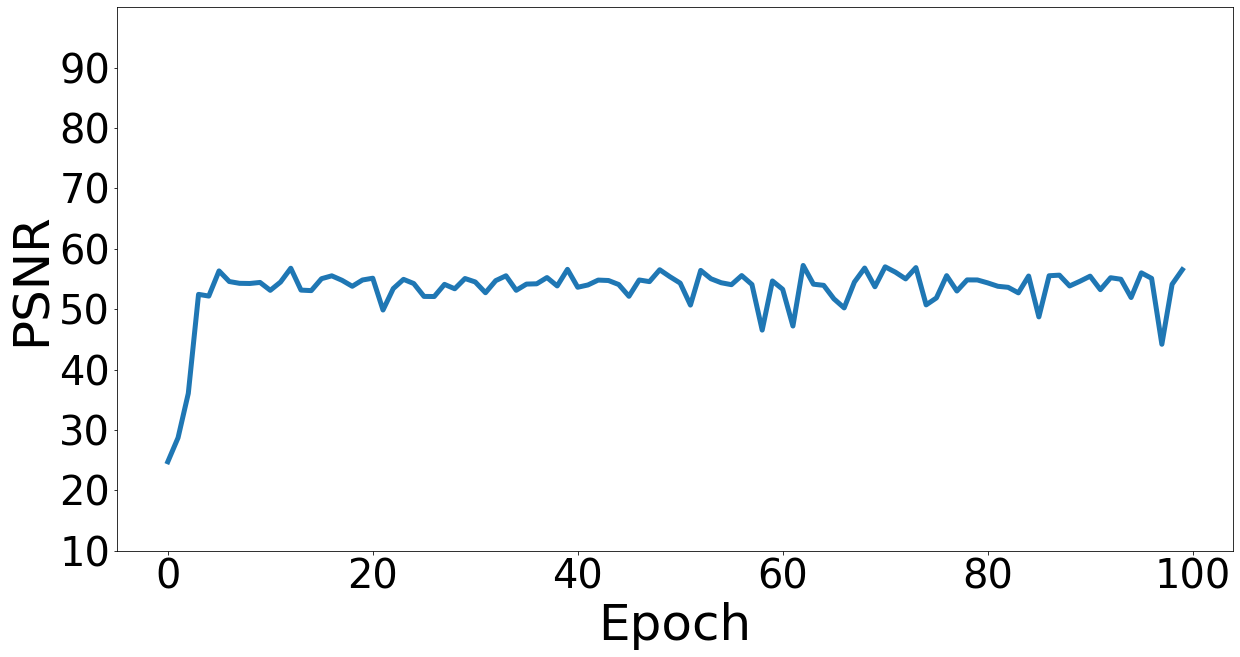

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-UP.pdf')
plt.show()



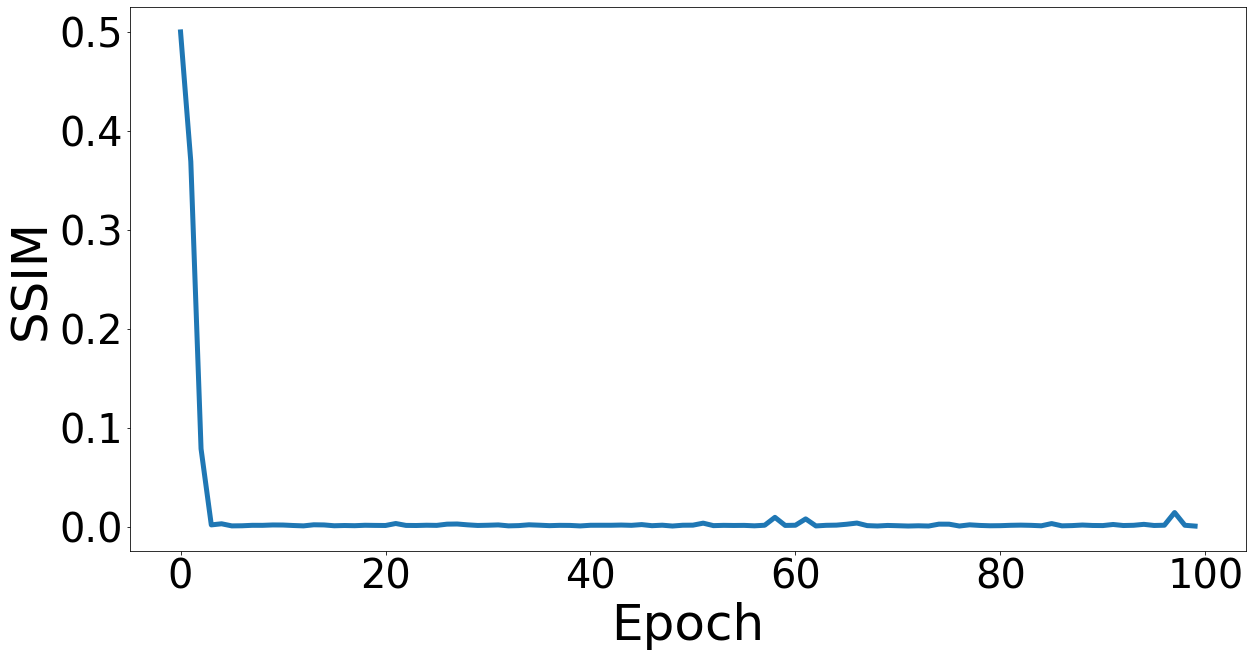

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-UP.pdf')

plt.show()


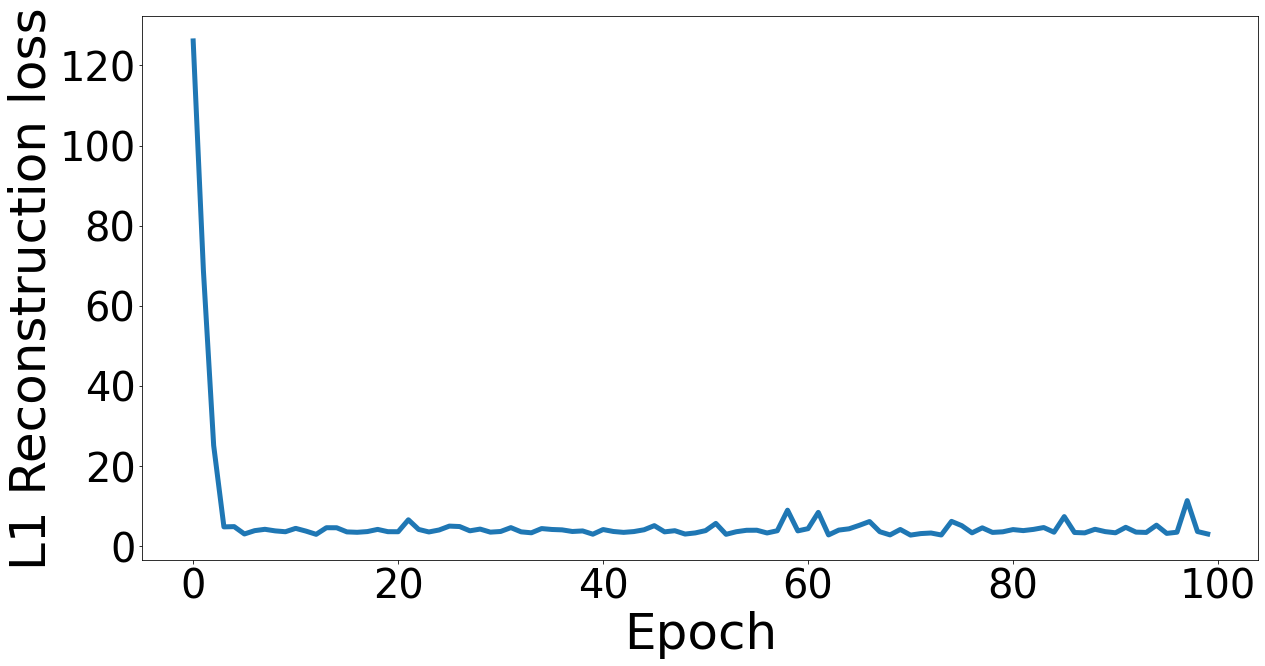

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-UP.pdf')
plt.show()



# Below this all are pertaining to analysis on max 15 bands.

In [0]:
dabsrecnet = [93, 14, 38, 50, 68, 95, 59, 5, 72, 6, 52, 60, 99, 25, 12, 100, 64, 31, 87, 34, 48, 47, 2, 57, 40][:15]
bsnetconv = [90, 42, 16, 48, 71, 3, 78, 38, 80, 53, 7, 31, 4, 99, 98]
pca = [48, 22, 51, 16, 52, 21, 65, 17, 20, 53, 18, 54, 19, 55, 76]
spabs = [50, 48, 16, 22, 4, 102, 21, 25, 23, 47, 24, 20, 31, 26, 42]
snmf = 	[92, 53, 43, 66, 22, 89, 82, 30, 51, 5, 83, 77, 80, 2, 48]
issc = [51, 76, 7, 64, 31, 8, 0, 24, 40, 30, 5, 3, 6, 27, 2]


In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20
    # entropy_lst = entropy(hist.transpose())
  info_div = 0
    # band_subset[np.nonzero(band_subset <= 0)] = 1e-20
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [0]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [0]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSD(dabsrecnet)
MSD(bsnetconv)
MSD(pca)
MSD(spabs)
MSD(snmf)
MSD(issc)




[ 7.761476738298997 , 4.6250930886642605 , 3.286261259369223 , 2.6735315239369344 , 3.3365203159180674 , 2.9914431632711427 , 3.0264805022211974 , 2.9727499692948567 , 2.980643802155538 , 2.725945769880003 , 2.536350410922844 , 2.692345767185834 , 2.620348474185831 ]
[ 5.115020684866051 , 4.526571682622963 , 3.213242304915848 , 2.97448512152231 , 3.042790109224713 , 3.3217558639808296 , 2.967694951964174 , 3.156246078795804 , 2.8854004074434467 , 2.934327640951193 , 2.7938956859548068 , 2.787570698604602 , 2.928527270645145 ]
[ 0.5244153283133781 , 0.37679756223118543 , 0.47795911772994204 , 0.43104468796658546 , 0.4154334082970964 , 0.43040469754638494 , 0.4456991684725939 , 0.4276403089184838 , 0.4195985289826393 , 0.416503828611406 , 0.410373930022122 , 0.404207147595373 , 0.3995683179989866 ]
[ 0.01817663534146942 , 0.5107047642337892 , 0.46638531133260347 , 0.553583302439063 , 2.564664641944027 , 2.2540341956189245 , 2.0163084298875735 , 1.8146029504421937 , 1.6473009773181007 , 1

In [0]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSA(dabsrecnet)
MSA(bsnetconv)
MSA(pca)
MSA(spabs)
MSA(snmf)
MSA(issc)




In [0]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [0]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    
EntropySum(dabsrecnet)
EntropySum(bsnetconv)
EntropySum(pca)
EntropySum(spabs)
EntropySum(snmf)
EntropySum(issc)



[ 24.596905683898903 , 36.80406837527877 , 49.0752255324909 , 61.29673610028988 , 74.01270441533634 , 86.32956289225699 , 98.00470708738979 , 110.09209563014278 , 121.77002302328165 , 134.05764549964186 , 146.377983957699 , 159.0451293997556 , 171.04316691326562 ]
[ 24.968807639700195 , 36.88696853977788 , 49.15856880069908 , 61.24023621270602 , 72.91085845035637 , 85.5009332190227 , 97.70809591040255 , 110.39161542254 , 122.68609661712048 , 134.37641588972338 , 146.41691011767307 , 158.10661557180953 , 170.77376101386614 ]
[ 24.257927502629578 , 36.539289054181374 , 48.45744995425906 , 60.74507243061926 , 72.73142381900985 , 85.03918434202522 , 96.97656153009385 , 108.95682806406492 , 121.25130925864542 , 133.20473399989996 , 145.49905522973228 , 157.46828504117207 , 169.76251182752327 ]
[ 24.542757418133327 , 36.460918318211014 , 48.447245559919395 , 60.13695101405584 , 72.83253122250325 , 84.81888261089384 , 96.81692012440385 , 108.79988297384614 , 121.06769009185244 , 133.053590512

### DUAL SSRN : Our Approach

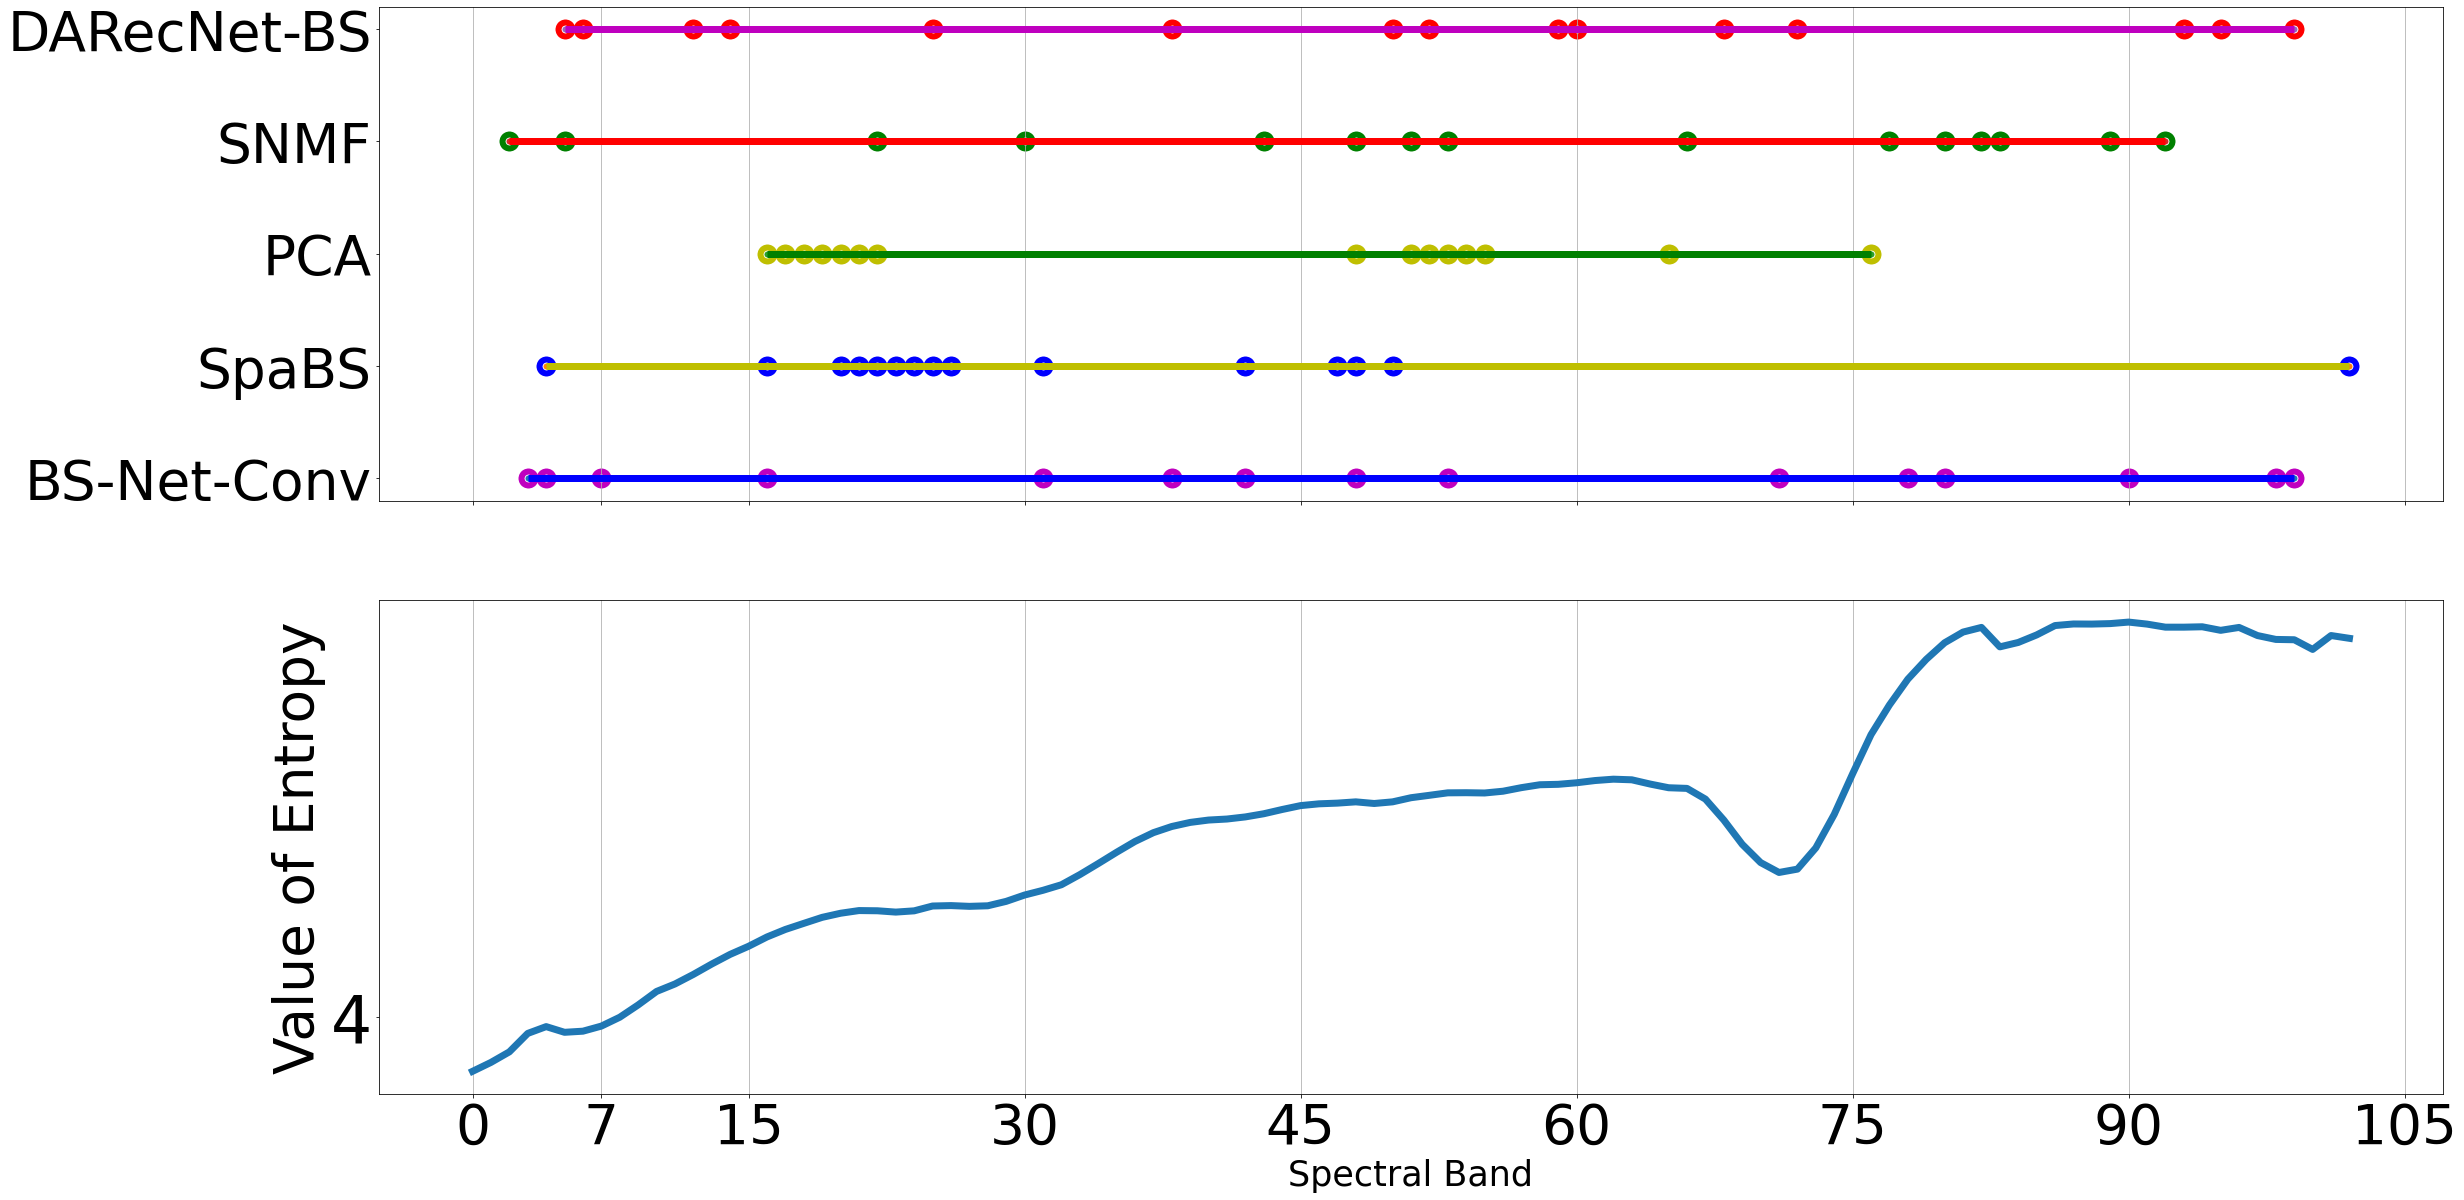

In [0]:
if not (os.path.isfile('/content/UP.csv')):
  !wget https://raw.githubusercontent.com/ucalyptus/Double-Branch-Dual-Attention-Mechanism-Network/master/UP.csv
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/UP.csv")
import matplotlib.pyplot as plt
X, _ = loadData()
n_row,n_column,n_band= X.shape
N = n_row * n_column
hist = []
Entropy  = []
for i in range(n_band):
  hist_, _ = np.histogram(X[:, :, i], 256)
  hist.append(hist_ / N)
  band_i = hist[i].reshape(-1)/np.sum(hist[i])
  entr_i = entropy(band_i)
  Entropy.append(entr_i)
 
for i in range(0,len(df['Selected Bands'])):
  df['Selected Bands'][i] = re.findall('[0-9]+', df['Selected Bands'][i])
  df['Selected Bands'][i] = [int(k) for k in df['Selected Bands'][i]]
meth = ["BS-Net-Conv","SpaBS","PCA","SNMF","DARecNet-BS"]
cols = ['b','y','g','r','m']
fig1,(ax1,ax2) = plt.subplots(2,sharex='col',figsize=(37,20))
ax1.grid(True)
ax1.yaxis.grid(False)
ax1.set_xticks([0,7,15,30,45,60,75,90,105,120,135,150,165,180,195,205])
ax1.yaxis.set_tick_params(labelsize=55)
plt.ylabel(meth)
scatar = []
for i in range(0,len(meth)):
  ax1.hlines(y = meth[i],xmin=min(df['Selected Bands'][i]),xmax=max(df['Selected Bands'][i]),colors=cols[i],linewidth=7)
  SCATTER = ax1.scatter(x=df['Selected Bands'][i],y = [i]*15,edgecolors=cols[i-1],linewidths=14)
  scatar.append(SCATTER)
ax2.grid(True)
ax2.yaxis.grid(False)
ax2.set_yticks([1,2,3,4,5])
ax2.set_ylabel("Value of Entropy",fontsize=55)
ax2.set_xlabel("Spectral Band",fontsize=35)
ax2.xaxis.set_tick_params(labelsize=55)
ax2.yaxis.set_tick_params(labelsize=65)
ax2.plot(Entropy,linewidth=7)
plt.savefig('Entropy_UP.pdf')

